## Compare benthic rover currents and wind stress curl forcing

In [1]:
%matplotlib notebook
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pycwt as wavelet

from physoce import tseries as ts
from scipy.stats import chi2

from airsea.windstress import stress
from oceans import cor_beta
from glob import glob
import gsw
import os.path

import datapath

/Users/tomconnolly/programs/anaconda/envs/stationm/lib/python3.7/site-packages/xarray/core/merge.py:10: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  PANDAS_TYPES = (pd.Series, pd.DataFrame, pd.Panel)


### Station M location

In [2]:
mlat = 35+8.4585/60  
mlon = -122-59.9036/60

### Load data

#### Benthic rover

Load data file created in [rover_analysis.ipynb](rover_analysis.ipynb)

In [3]:
df_sub = pd.read_csv('data/rover_processed_2015_2018.csv',parse_dates=[0])
df_sub = df_sub.set_index('Date_time_R')

# resample and interpolate
df = df_sub.resample('3H').mean()

#### NCEP-NARR

In [4]:
narr_dir = datapath.narr()

u_file_list = sorted(glob(os.path.join(narr_dir,'uwnd.10m.*.nc')))
v_file_list = sorted(glob(os.path.join(narr_dir,'vwnd.10m.*.nc')))

uds = xr.open_mfdataset(u_file_list)
vds = xr.open_mfdataset(v_file_list)

/Users/tomconnolly/programs/anaconda/envs/stationm/lib/python3.7/site-packages/xarray/conventions.py:362: SerializationWarning: variable 'uwnd' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  stack_char_dim=stack_char_dim)
/Users/tomconnolly/programs/anaconda/envs/stationm/lib/python3.7/site-packages/xarray/conventions.py:362: SerializationWarning: variable 'uwnd' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  stack_char_dim=stack_char_dim)
/Users/tomconnolly/programs/anaconda/envs/stationm/lib/python3.7/site-packages/xarray/conventions.py:362: SerializationWarning: variable 'uwnd' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  stack_char_dim=stack_char_dim)
/Users/tomconnolly/programs/anaconda/envs/stationm/lib/python3.7/site-packages/xarray/conventions.py:362: SerializationWarning: variable 'uwnd' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to Na

#### Find NCEP-NARR indices of nearest point to Station M

In [5]:
dist = np.array(np.sqrt(((mlat-uds['lat'])*111)**2 + 
                        ((mlon-uds['lon'])*np.cos(mlat*np.pi/180)*111)**2))

In [6]:
idx = np.argmin(dist,axis=None)
ii,jj = np.unravel_index(idx,np.shape(dist))

#### Compute local wind stress curl forcing

In [7]:
dx = 0.5*np.array(vds['x'][jj+1] - vds['x'][jj-1])
dy = 0.5*np.array(uds['y'][ii+1] - uds['y'][ii-1])

f = np.array(gsw.f(uds['lat']))
rho = 1045

beta = np.array(cor_beta(uds['lat'][ii,jj]))
beta_eff = 7.3e-11
H = 4000

In [8]:
ext = 2 # length of subset on either side of center
ci = ext  # center index

In [9]:
uwndsub = np.array(uds['uwnd'][:,np.arange(ii-ext,ii+ext+1),np.arange(jj-ext,jj+ext+1)])
vwndsub = np.array(vds['vwnd'][:,np.arange(ii-ext,ii+ext+1),np.arange(jj-ext,jj+ext+1)])

In [10]:
fsub = f[slice(ii-ext,ii+ext+1),slice(jj-ext,jj+ext+1)]

#### Wind stress components

In [11]:
taux = stress(uwndsub)
tauy = stress(vwndsub)

#### Forcing term

Forcing term in Koblinsky et al. (1989), 

$$ F = f \nabla \times \frac{\tau^s}{\rho_o f} $$

Normalizing by $\beta H$ gives the magnitude of depth-averaged currents associated with Sverdrup balance over a flat bottom. 

Second order difference

In [12]:
curl_tau_F_2 = fsub[ci,ci]*((1/(2*dx))*(tauy[:,ci,ci+1]/(rho*fsub[ci,ci+1]) - 
                           tauy[:,ci,ci-1]/(rho*fsub[ci,ci-1])) - 
           (1/(2*dy))*(taux[:,ci+1,ci]/(rho*fsub[ci+1,ci]) - 
                   taux[:,ci-1,ci]/(rho*fsub[ci-1,ci])))

Fourth order difference

In [13]:
curl_tau_F = fsub[ci,ci]*((1/(12*dx))*(-tauy[:,ci,ci+2]/(rho*fsub[ci,ci+2]) + 
                                         8*tauy[:,ci,ci+1]/(rho*fsub[ci,ci+1]) - 
                                         8*tauy[:,ci,ci-1]/(rho*fsub[ci,ci-1]) +
                                         tauy[:,ci,ci-2]/(rho*fsub[ci,ci-2])) -
           (1/(12*dy))*(-taux[:,ci+2,ci]/(rho*fsub[ci+2,ci]) +
                        8*taux[:,ci+1,ci]/(rho*fsub[ci+1,ci]) -
                        8*taux[:,ci-1,ci]/(rho*fsub[ci-1,ci]) +
                        taux[:,ci-2,ci]/(rho*fsub[ci-2,ci])))

Check for consistency between derivative methods

<IPython.core.display.Javascript object>


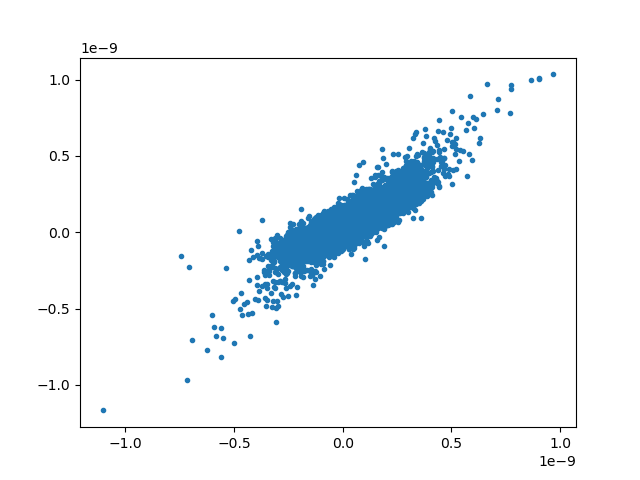

In [23]:
plt.figure()
plt.plot(curl_tau_F_2,curl_tau_F,'.')

Find indices that overlap with Rover data

In [24]:
t1 = np.datetime64('2015-11-11T12:00')
t2 = np.datetime64('2018-10-14T06:00')

curl_time = uds['time']
fi, = np.where((curl_time >= t1) & (curl_time <= t2))

### Initial plots

Compare magnitudes of forcing and observed currents

<IPython.core.display.Javascript object>


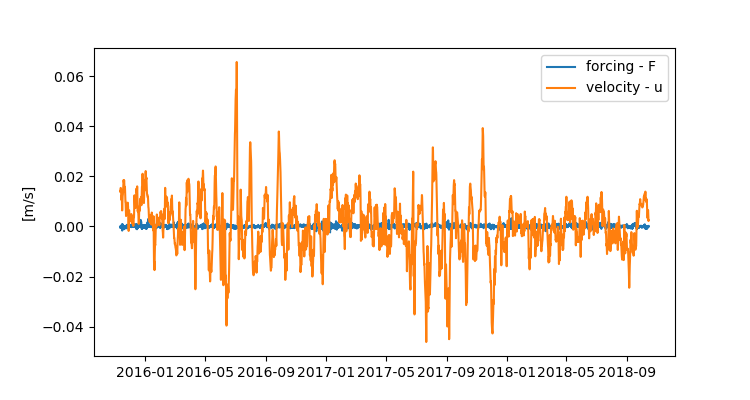

Text(0, 0.5, '[m/s]')

In [25]:
plt.figure(figsize=(7.5,4))
plt.plot(curl_time[fi],curl_tau_F_2[fi]/(beta_eff*H))
plt.plot(df.index,df['u_f'])
plt.legend(['forcing - F','velocity - u'])
plt.ylabel('[m/s]')

### Wavelet analysis

Analysis and plotting based on examples in PyCWT documentation
https://pycwt.readthedocs.io/

##### Rover data in Numpy arrays

In [26]:
u = np.array(df['u'])
v = np.array(df['v'])

N = len(u)

##### Normalized time series

In [27]:
fstd = np.std(curl_tau_F_2[fi]/(beta_eff*H))  # Standard deviation
fvar = fstd ** 2  # Variance
f_norm = curl_tau_F_2[fi]/(beta_eff*H) / fstd  # Normalized dataset

wstd = np.std(np.squeeze(tauy[fi,ci,ci]))  # Standard deviation
wvar = wstd ** 2  # Variance
w_norm = np.squeeze(tauy[fi,ci,ci]) / wstd  # Normalized dataset

ustd = np.std(u)  # Standard deviation
uvar = ustd ** 2  # Variance
u_norm = u / ustd  # Normalized dataset

vstd = np.std(v)  # Standard deviation
vvar = vstd ** 2  # Variance
v_norm = v / vstd  # Normalized dataset

dt = 1/8 # days

mother = wavelet.Morlet(6)
s0 = 2 * dt  # Starting scale, in this case 2 * 0.25 years = 6 months
dj = 1 / 12  # Twelve sub-octaves per octaves
J = 11 / dj  # Seven powers of two with dj sub-octaves
alphau, _, _ = wavelet.ar1(u_norm)  # Lag-1 autocorrelation for red noise
alphav, _, _ = wavelet.ar1(v_norm)  # Lag-1 autocorrelation for red noise
alphaf, _, _ = wavelet.ar1(f_norm)  # Lag-1 autocorrelation for red noise
alphaw, _, _ = wavelet.ar1(w_norm)  # Lag-1 autocorrelation for red noise

##### Continuous wavelet transform

In [28]:
uwave, uscales, ufreqs, ucoi, ufft, ufftfreqs = wavelet.cwt(u_norm, dt, dj, s0, J,
                                                      mother)

vwave, vscales, vfreqs, vcoi, vfft, vfftfreqs = wavelet.cwt(v_norm, dt, dj, s0, J,
                                                      mother)

fwave, fscales, ffreqs, fcoi, ffft, ffftfreqs = wavelet.cwt(f_norm, dt, dj, s0, J,
                                                      mother)

wwave, wscales, wfreqs, wcoi, wfft, wfftfreqs = wavelet.cwt(w_norm, dt, dj, s0, J,
                                                      mother)

##### Significance levels

In [29]:
upower = (np.abs(uwave)) ** 2
ufft_power = np.abs(ufft) ** 2
uperiod = 1 / ufreqs

usignif, ufft_theor = wavelet.significance(1.0, dt, uscales, 0, alphau,
                                         significance_level=0.99,
                                         wavelet=mother)
usig99 = np.ones([1, N]) * usignif[:, None]
usig99 = upower / usig99

vpower = (np.abs(vwave)) ** 2
vfft_power = np.abs(vfft) ** 2
vperiod = 1 / vfreqs

vsignif, vfft_theor = wavelet.significance(1.0, dt, vscales, 0, alphav,
                                         significance_level=0.99,
                                         wavelet=mother)
vsig99 = np.ones([1, N]) * vsignif[:, None]
vsig99 = vpower / vsig99

fpower = (np.abs(fwave)) ** 2
ffft_power = np.abs(ffft) ** 2
fperiod = 1 / ffreqs

fsignif, ffft_theor = wavelet.significance(1.0, dt, fscales, 0, alphaf,
                                         significance_level=0.99,
                                         wavelet=mother)
fsig99 = np.ones([1, N]) * fsignif[:, None]
fsig99 = fpower / fsig99

wpower = (np.abs(wwave)) ** 2
wfft_power = np.abs(wfft) ** 2
wperiod = 1 / wfreqs

wsignif, wfft_theor = wavelet.significance(1.0, dt, wscales, 0, alphaw,
                                         significance_level=0.99,
                                         wavelet=mother)
wsig99 = np.ones([1, N]) * wsignif[:, None]
wsig99 = wpower / wsig99

### Plots

<IPython.core.display.Javascript object>


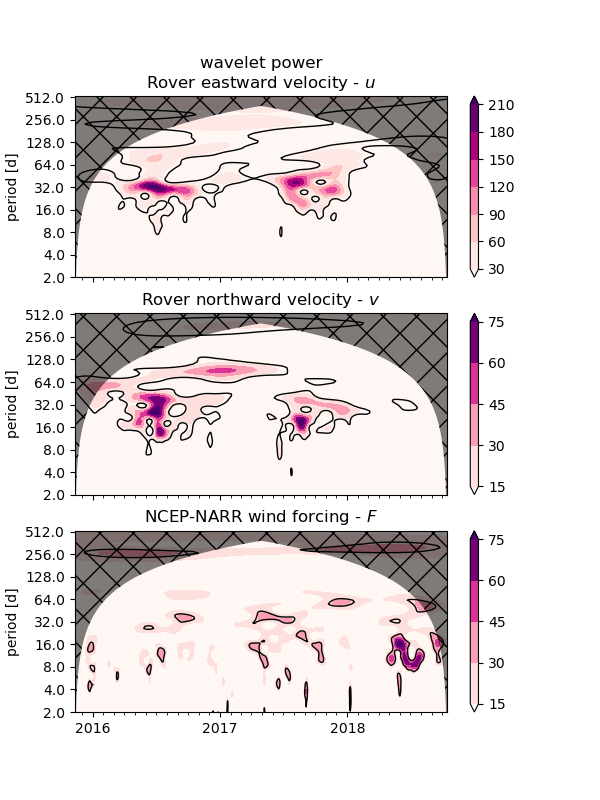

In [31]:
t = mdates.date2num(curl_time[fi])

years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
years_fmt = mdates.DateFormatter('%Y')

plt.figure(figsize=(6,8))

ax1 = plt.subplot(311)
plt.contourf(t, np.log2(uperiod), upower,
            extend='both',cmap='RdPu')
plt.colorbar()
plt.contour(t, np.log2(uperiod), usig99, [-99, 1], colors='k', linewidths=1)
yticks = 2 ** np.arange(np.ceil(np.log2(uperiod.min())),
                           np.ceil(np.log2(uperiod.max())))
ax1.set_yticks(np.log2(yticks))
ax1.set_yticklabels(yticks)
ax1.xaxis.set_major_locator(years)
ax1.xaxis.set_major_formatter(years_fmt)
ax1.xaxis.set_minor_locator(months)
ax1.set_xticklabels([])
plt.ylim([np.log2(2),np.log2(uperiod.max())])
plt.fill(np.concatenate([t, t[-1:] + dt, t[-1:] + dt,
                           t[:1] - dt, t[:1] - dt]),
        np.concatenate([np.log2(ucoi), [1e-9], np.log2(uperiod[-1:]),
                           np.log2(uperiod[-1:]), [1e-9]]),
        'k', alpha=0.5, hatch='x')
plt.xticks(rotation=30)
plt.ylabel('period [d]')
plt.title('wavelet power\nRover eastward velocity - $u$')

ax2 = plt.subplot(312)
plt.contourf(t, np.log2(vperiod), vpower,
            extend='both',cmap='RdPu')
plt.colorbar()
plt.contour(t, np.log2(vperiod), vsig99, [-99, 1], colors='k', linewidths=1)
yticks = 2 ** np.arange(np.ceil(np.log2(vperiod.min())),
                           np.ceil(np.log2(vperiod.max())))
ax2.set_yticks(np.log2(yticks))
ax2.set_yticklabels(yticks)
ax2.xaxis.set_major_locator(years)
ax2.xaxis.set_major_formatter(years_fmt)
ax2.xaxis.set_minor_locator(months)
ax2.set_xticklabels([])
plt.ylim([np.log2(2),np.log2(vperiod.max())])
plt.fill(np.concatenate([t, t[-1:] + dt, t[-1:] + dt,
                           t[:1] - dt, t[:1] - dt]),
        np.concatenate([np.log2(vcoi), [1e-9], np.log2(vperiod[-1:]),
                           np.log2(vperiod[-1:]), [1e-9]]),
        'k', alpha=0.5, hatch='x')
plt.xticks(rotation=30)
plt.ylabel('period [d]')
plt.title('Rover northward velocity - $v$')

ax3 = plt.subplot(313)
plt.contourf(t, np.log2(fperiod), fpower,
            extend='both',cmap='RdPu')
plt.colorbar()
plt.contour(t, np.log2(fperiod), fsig99, [-99, 1], colors='k', linewidths=1)
yticks = 2 ** np.arange(np.ceil(np.log2(fperiod.min())),
                           np.ceil(np.log2(fperiod.max())))
ax3.set_yticks(np.log2(yticks))
ax3.set_yticklabels(yticks)
plt.ylim([np.log2(2),np.log2(fperiod.max())])
plt.fill(np.concatenate([t, t[-1:] + dt, t[-1:] + dt,
                           t[:1] - dt, t[:1] - dt]),
        np.concatenate([np.log2(fcoi), [1e-9], np.log2(fperiod[-1:]),
                           np.log2(fperiod[-1:]), [1e-9]]),
        'k', alpha=0.5, hatch='x')
plt.ylabel('period [d]')
plt.title('NCEP-NARR wind forcing - $F$')

ax3.xaxis.set_major_locator(years)
ax3.xaxis.set_major_formatter(years_fmt)
ax3.xaxis.set_minor_locator(months)

plt.savefig('figures_paper/wavelet_power.png',dpi=1000)
plt.savefig('figures_paper/wavelet_power.pdf')